In [1]:
%load_ext autoreload
%autoreload complete
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from tqdm.notebook import tqdm

from protest_impact.util import cache, project_root

In [2]:
path = project_root / "datasets/official-data/raw/"
df = pd.DataFrame()
for file in ["berlin1.xlsx", "berlin2.xlsx"]:
    dfname = pd.ExcelFile(path / file)
    for name in dfname.sheet_names:
        print(name)
        dfnew = pd.read_excel(path / file, sheet_name=name)
        print(dfnew.shape)
        print(dfnew["Teilnehmer"].sum())
        df = pd.concat([df, dfnew])
berlin = df
berlin["date"] = pd.to_datetime(berlin["Datum"], dayfirst=True)
berlin.head()

versammlungen-berlin
(12774, 6)
9778956
2020 (07-12)
(2992, 10)
17493192.0
2021
(6220, 10)
1229467.0
2022
(6455, 10)
2032426.0


,Datum,Thema,Teilnehmer,Teilnehmer (tatsächlich),Kategorie,Stichwörter,Von,Bis,Strasse,Nr,PLZ,Aufzugsstrecke,date
0,2018-01-01 00:00:00,Gegen das Regierungsregime im Iran,50.0,50.0,Ausland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01
1,2018-01-01 00:00:00,Gegen Menschenrechtsverletzungen von Saudische...,30.0,11.0,Ausland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01
2,2018-01-01 00:00:00,Mahnwache zur Erinnerung an die Opfer des atom...,20.0,2.0,Ausland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01
3,2018-01-01 00:00:00,Stoppt die Verfolgung von Falun Gong-Praktizie...,10.0,3.0,Ausland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01
4,2018-01-01 00:00:00,Solidarität mit den Revoltierenden im Iran,50.0,150.0,Ausland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01


In [3]:
berlin = berlin.dropna(subset=["Teilnehmer", "Teilnehmer (tatsächlich)"])
berlin = berlin[(berlin["Teilnehmer"] > 0) & (berlin["Teilnehmer (tatsächlich)"] > 0)]
x = berlin["Teilnehmer"]
y = berlin["Teilnehmer (tatsächlich)"]
lx, ly = np.log10(x), np.log10(y)

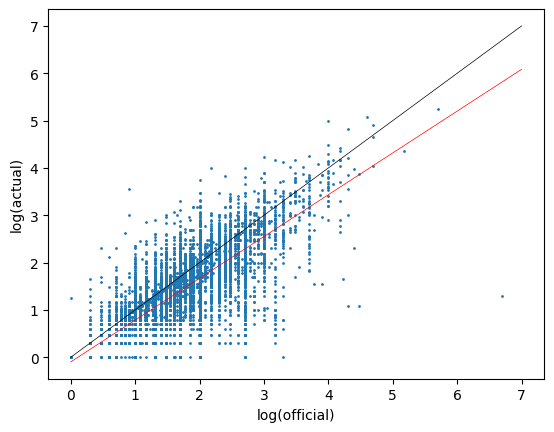

In [4]:
plt.scatter(lx, ly, s=1)
# diagonal line
plt.plot([0, 7], [0, 7], color="black", linewidth=0.5)
# regression line
model = sm.OLS(ly, sm.add_constant(lx))
results = model.fit()
x_ = np.log10(np.linspace(1, 1e7, 100))
plt.plot(x_, results.predict(sm.add_constant(x_)), color="red", linewidth=0.5)
plt.xlabel("log(official)")
plt.ylabel("log(actual)")
plt.show()

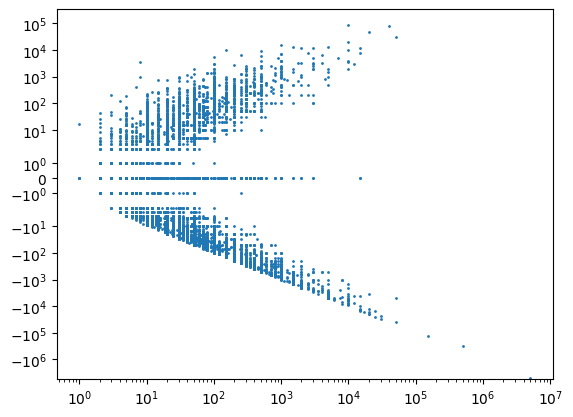

In [5]:
plt.scatter(x, y - x, s=1)
x_ = np.log(np.linspace(1, 1e7, 100))
plt.xscale("log")
plt.yscale("symlog")
plt.show()

In [6]:
def filter_climate_words(x):
    climate_Words = ["fridays4future", "fridaysforfuture", "klimastreik"]
    return any(y in x.lower().replace(" ", "") for y in climate_Words)


klima = berlin.query("date >= '2020-01-01' and date <= '2022-12-31'")
klima = berlin[berlin["Thema"].apply(filter_climate_words)]
klima["Thema"].value_counts()

Fridays For Future ‐ Klimastreik                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         37
"Die Klimakrise ist durch ihre Komplexität und ihr Ausmaß die fundamentalste Krise in der sich die Menschheit jemals befunden hat. Die aktuelle Klimapolitik

In [7]:
klima = klima.groupby("date").sum().reset_index().drop(columns=["PLZ"])
klima = klima.query("date >= '2020-01-01' and date <= '2022-12-31'")
klima = klima.rename(
    columns={
        "Teilnehmer": "size_moderate_registered",
        "Teilnehmer (tatsächlich)": "size_moderate_official",
    }
)
klima.head()

/var/folders/6v/w9nn6c_n4qdbrjwfnq7695n00000gn/T/ipykernel_14685/3337585602.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  klima = klima.groupby("date").sum().reset_index().drop(columns=["PLZ"])


,date,size_moderate_registered,size_moderate_official
53,2020-01-03,32.0,32.0
54,2020-01-10,12.0,8.0
55,2020-01-13,50.0,150.0
56,2020-01-24,312.0,605.0
57,2020-01-31,312.0,157.0


In [8]:
df = pd.read_csv(project_root / "data/daily_data.csv")
df["date"] = pd.to_datetime(df["date"])
df = df.query("region == 'Berlin'")
df = df.rename(columns={"size_moderate": "size_moderate_acled"})
df.head()

,date,region,size_radical,size_moderate_acled,count_radical,count_moderate,climate_and_protest_mediacloud,climate_not_protest_mediacloud,climate_mediacloud,pres,prcp,new_tests_smoothed_per_thousand,stringency_index,weekday,is_holiday
6,2020-01-01,Berlin,0.0,0.0,0.0,0.0,4,13,17,1032.9,0.0,0.0,0.0,Wednesday,True
20,2020-01-02,Berlin,0.0,0.0,0.0,0.0,12,13,25,1027.1,0.0,0.0,0.0,Thursday,False
34,2020-01-03,Berlin,0.0,0.0,0.0,0.0,6,12,18,1017.8,4.1,0.0,0.0,Friday,False
48,2020-01-04,Berlin,0.0,0.0,0.0,0.0,3,5,8,1019.5,4.4,0.0,0.0,Saturday,False
62,2020-01-05,Berlin,0.0,0.0,0.0,0.0,5,10,15,1031.9,0.0,0.0,0.0,Sunday,False


In [9]:
df = df.merge(klima, on="date", how="outer").fillna(0)
df.head()

,date,region,size_radical,size_moderate_acled,count_radical,count_moderate,climate_and_protest_mediacloud,climate_not_protest_mediacloud,climate_mediacloud,pres,prcp,new_tests_smoothed_per_thousand,stringency_index,weekday,is_holiday,size_moderate_registered,size_moderate_official
0,2020-01-01,Berlin,0.0,0.0,0.0,0.0,4,13,17,1032.9,0.0,0.0,0.0,Wednesday,True,0.0,0.0
1,2020-01-02,Berlin,0.0,0.0,0.0,0.0,12,13,25,1027.1,0.0,0.0,0.0,Thursday,False,0.0,0.0
2,2020-01-03,Berlin,0.0,0.0,0.0,0.0,6,12,18,1017.8,4.1,0.0,0.0,Friday,False,32.0,32.0
3,2020-01-04,Berlin,0.0,0.0,0.0,0.0,3,5,8,1019.5,4.4,0.0,0.0,Saturday,False,0.0,0.0
4,2020-01-05,Berlin,0.0,0.0,0.0,0.0,5,10,15,1031.9,0.0,0.0,0.0,Sunday,False,0.0,0.0


/Users/david/Repositories/protest-impact/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


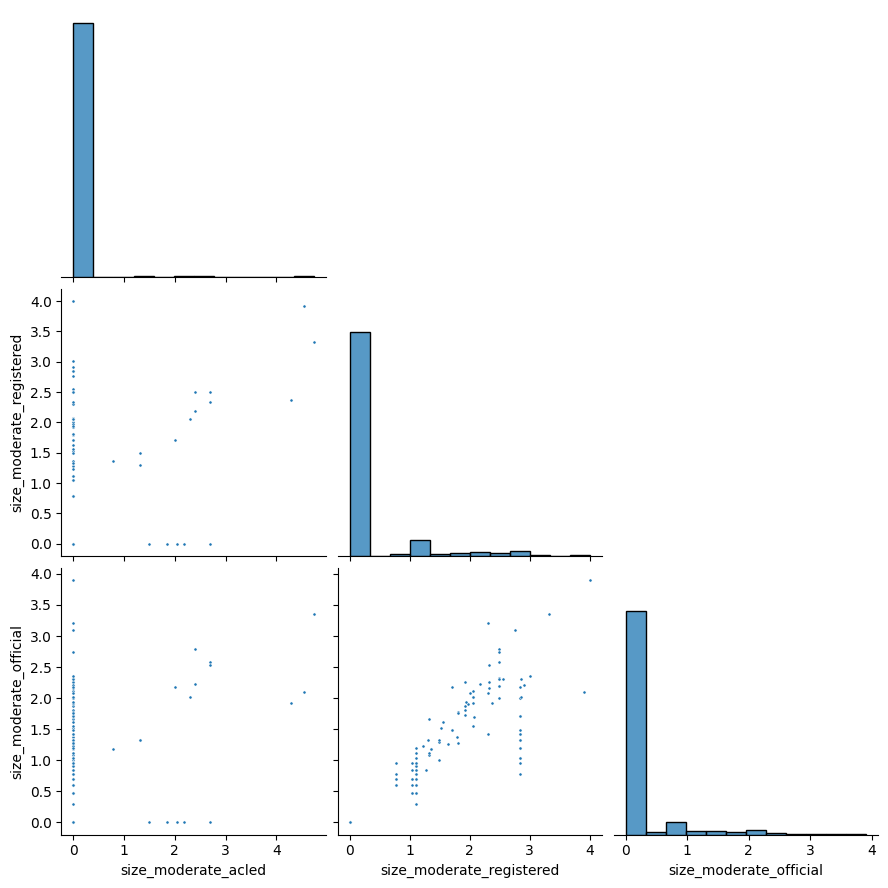

In [10]:
log_df = df[
    ["size_moderate_acled", "size_moderate_registered", "size_moderate_official"]
].apply(lambda x: np.log10(x + 1))
sns.pairplot(log_df, corner=True, size=3, markers=".", plot_kws={"s": 20})
plt.show()

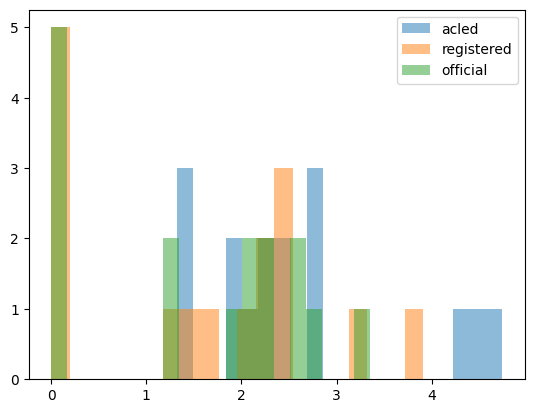

In [11]:
log_df_ = log_df[log_df["size_moderate_acled"] > 1]
plt.hist(log_df_["size_moderate_acled"], label="acled", alpha=0.5, bins=20)
plt.hist(log_df_["size_moderate_registered"], label="registered", alpha=0.5, bins=20)
plt.hist(log_df_["size_moderate_official"], label="official", alpha=0.5, bins=20)
plt.legend()
plt.show()

/var/folders/6v/w9nn6c_n4qdbrjwfnq7695n00000gn/T/ipykernel_14685/3256989769.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = df.groupby(pd.Grouper(key="date", freq="M")).sum().reset_index()


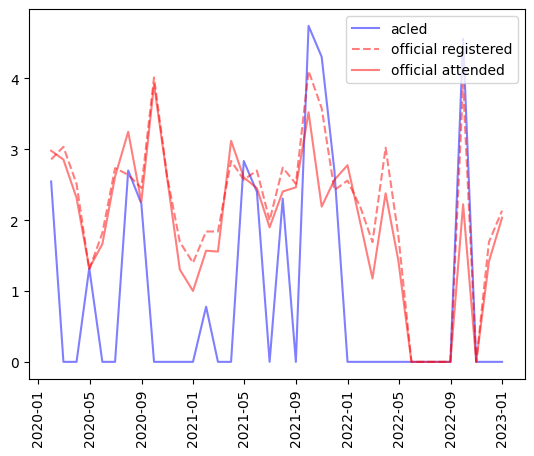

In [12]:
agg_df = df.groupby(pd.Grouper(key="date", freq="M")).sum().reset_index()
plt.plot(
    agg_df["date"],
    np.log10(agg_df["size_moderate_acled"] + 1),
    label="acled",
    linestyle="-",
    color="blue",
    alpha=0.5,
)
plt.plot(
    agg_df["date"],
    np.log10(agg_df["size_moderate_registered"] + 1),
    label="official registered",
    linestyle="--",
    color="red",
    alpha=0.5,
)
plt.plot(
    agg_df["date"],
    np.log10(agg_df["size_moderate_official"] + 1),
    label="official attended",
    linestyle="-",
    color="red",
    alpha=0.5,
)
plt.xticks(rotation=90)
plt.legend()
plt.show()